In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
from tensorflow import keras

In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [6]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(test_images.shape)

model=tf.keras.models.load_model('my_org_model_top4_quant.h5')

a = model.get_weights()

#which means that it will return the input tensors of each layer in the original model. 
#This allows you to access the intermediate activations of all layers in the model for a given input.
extractor_in = keras.Model(inputs=model.inputs,
                        outputs=[layer.input for layer in model.layers])

# The 'test_images' data is passed through the extractor_in model, 
#and the output of this operation is stored in the features_in variable. 
#As a result, features_in will be a list of arrays, 
#with each array corresponding to the activations of the corresponding layer in the original model.
features_in = extractor_in(test_images)

(10000, 28, 28)


In [7]:
Multiplier_Exact=np.zeros([256,256])
for i in range(-128,128):
    for j in range(-128,128):
        Multiplier_Exact[i+128,j+128]=i*j



In [8]:
Multiplier_Approx0=Multiplier_Exact
Multiplier_Approx1=np.load("Approximate Mult1.npy")
Multiplier_Approx2=np.load("Approximate Mult2.npy")
Multiplier_Approx3=np.load("Approximate Mult3.npy")
Multiplier_Approx4=np.load("Approximate Mult4.npy")
Multiplier_Approx5=np.load("Approximate Mult5.npy")
Multiplier_Approx6=np.load("Approximate Mult6.npy")
Multiplier_Approx7=np.load("Approximate Mult7.npy")
Multiplier_Approx8=np.load("Approximate Mult8.npy")

In [9]:
def My_Mult_Var(a,b,t=0):
    if t==0:
        Multiplier_Approx=Multiplier_Approx0
    if t==1:
        Multiplier_Approx=Multiplier_Approx1
    if t==2:
        Multiplier_Approx=Multiplier_Approx2
    if t==3:
        Multiplier_Approx=Multiplier_Approx3
    if t==4:
        Multiplier_Approx=Multiplier_Approx4
    if t==5:
        Multiplier_Approx=Multiplier_Approx5
    if t==6:
        Multiplier_Approx=Multiplier_Approx6
    if t==7:
        Multiplier_Approx=Multiplier_Approx7
    if t==8:
        Multiplier_Approx=Multiplier_Approx8

    a=np.array(a)
    b=np.array(b)
    a_shape=np.shape(a)
    b=np.reshape(b,a_shape)
    res=np.zeros(a_shape)
    if len(a_shape)==1:
        for i in range(np.shape(a)[0]):
            res[i]=Multiplier_Approx[int(a[i])+128,int(b[i])+128]
    if len(a_shape)==2:
        for i in range(a_shape[0]):
            for j in range(a_shape[1]):
                res[i,j]=Multiplier_Approx[int(a[i,j])+128,int(b[i,j])+128]
    return res

In [10]:
def My_Matmul_LT_Var(a,b,t=0):
    a=np.array(a)
    b=np.array(b)
    a_shape=np.shape(a)
    b_shape=np.shape(b)
    res=np.zeros([a_shape[0],b_shape[1]])
    for i in range(a_shape[0]):
        for j in range(b_shape[1]):
            res[i,j]=np.sum(My_Mult_Var(a[i,:],b[:,j],t))
    return res

In [11]:
def My_Conv2d_LT_Var(a,b,t=0):
    a=np.array(a)
    b=np.array(b)
    a_shape=np.shape(a)
    b_shape=np.shape(b)
    res_shape1=np.abs(a_shape[0]-b_shape[0])+1
    res_shape2=np.abs(a_shape[1]-b_shape[1])+1
    res=np.zeros([res_shape1,res_shape2])
    for i in range(res_shape1):
        for j in range(res_shape2):
            res[i,j]=np.sum(My_Mult_Var(np.flip(b),a[i:i+b_shape[0],j:j+b_shape[1]],t))
    return res

In [12]:
def CNN_Visual(k,t):  # First Input Determines the Number of the Test Image, 
                            # and Second one Determines the Type of the Multiplier
    z1=np.floor(features_in[0][k]/2)     # Quantization
    z2=np.zeros([28,28,64])
    for i in range(64):
        for j in range(1):
            z2[:,:,i]=z2[:,:,i]+My_Conv2d_LT_Var(np.array(z1[:,:,j]),np.flip(a[0][:,:,j,i]),t)
        z2[:,:,i]=z2[:,:,i]+a[1][i]
    z3=np.maximum(0,z2)                 # ReLU
    z3=np.round((z3/np.max(z3))*127)    # Quantization
    z4=np.zeros([28,28,32])
    for i in range(32):
        for j in range(64):
             z4[:,:,i]=z4[:,:,i]+My_Conv2d_LT_Var(np.array(z3[:,:,j]),np.flip(a[2][:,:,j,i]),t)
        z4[:,:,i]=z4[:,:,i]+a[3][i]
    z5=np.maximum(0,z4)                # ReLU
    z5=np.round((z5/np.max(z5))*127)   # Quantization
    z6=np.zeros([28,28,16])
    for i in range(16):
        for j in range(32):
             z6[:,:,i]=z6[:,:,i]+My_Conv2d_LT_Var(np.array(z5[:,:,j]),np.flip(a[4][:,:,j,i]),t)
        z6[:,:,i]=z6[:,:,i]+a[5][i]
    z61=np.maximum(0,z6)              # ReLU
    z61=np.round((z61/np.max(z61))*127) # Quantization
    z7=np.zeros([26,26,8])
    for i in range(8):
        for j in range(16):
             z7[:,:,i]=z7[:,:,i]+My_Conv2d_LT_Var(np.array(z61[:,:,j]),np.flip(a[6][:,:,j,i]),t)
        z7[:,:,i]=z7[:,:,i]+a[7][i]
    z8=np.maximum(0,z7)                # ReLU
    z8=np.round((z8/np.max(z8))*127)   # Quantization
    z9=np.zeros([24,24,4])
    for i in range(4):
        for j in range(8):
             z9[:,:,i]=z9[:,:,i]+My_Conv2d_LT_Var(np.array(z8[:,:,j]),np.flip(a[8][:,:,j,i]),t)
        z9[:,:,i]=z9[:,:,i]+a[9][i]
    z10=np.maximum(0,z9)              # ReLU
    z10=np.round((z10/np.max(z10))*127)  # Quantization
    z13=np.reshape(z10,[1,-1])  #  Flatten layer
    z14=My_Matmul_LT_Var(z13,a[10],t)+a[11]  
    z15=np.maximum(0,z14) # ReLU
    z15=np.round((z15/np.max(z15))*127)  # Quantization
    z141=My_Matmul_LT_Var(z15,a[12],t)+a[13] # ReLU
    z151=np.maximum(0,z141)
    z151=np.round((z151/np.max(z151))*127) # Quantization
    z16=My_Matmul_LT_Var(z151,a[14],t)+a[15]
    z16=np.round((z16/np.max(z16))*127) # Quantization
    return np.argmax(z16), z3,z5,z61,z8,z10,z15,z151,z16

In [14]:
Vis_Mat=[]
for i in range(9):
    Vis_Mat.append(CNN_Visual(30,i))

images=[]
Layer_Number=3
for i in range(9):
    images.append(Vis_Mat[i][Layer_Number])

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Loop through your image data and plot each image on a subplot
for i, ax in enumerate(axes.ravel()):
    # Check if there are more images than subplots
    image_data=np.average(images,axis=-1)
    if i < len(image_data):
        ax.imshow(image_data[i])  # Plot the image
        ax.set_title(f'Approximate Multiplier {i}')  # Set a title for the subplot
    else:
        ax.axis('off')  # Turn off the empty subplots if there are fewer images

# Adjust spacing between subplots for better visualization
plt.tight_layout()

# Display the plot
plt.show()

#Result after CNN
Vis_Mat[0][0]

Traceback (most recent call last):
  File "/home/mburr/mambaforge-pypy3/envs/ecp/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined
Traceback (most recent call last):
  File "/home/mburr/mambaforge-pypy3/envs/ecp/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined


In [16]:
# Assuming you have already loaded the model and test data

# Compile the model if it's not already compiled
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy}')


313/313 [==============================] - 1s 4ms/step - loss: 56280846826504978432.0000 - accuracy: 0.9925
Test accuracy: 0.9925000071525574


313/313 [==============================] - 1s 4ms/step


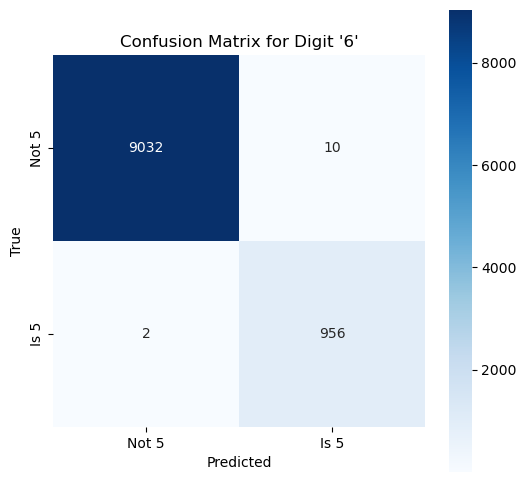

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


predictions = model.predict(test_images)

# Find the indices of true "5" labels and predicted "5" labels
true_indices = (test_labels == 6)
predicted_indices = (np.argmax(predictions, axis=1) == 6)

# Create a confusion matrix for the digit "5"
confusion = confusion_matrix(true_indices, predicted_indices)

# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=["Not 5", "Is 5"],
            yticklabels=["Not 5", "Is 5"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix for Digit '6'")
plt.show()


